In [ ]:
# default_exp model.core

In [ ]:
# export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data import *

from sklearn.neighbors import NearestNeighbors

import umap #!conda install -c conda-forge umap-learn 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from seaborn import heatmap
from sklearn.linear_model import LogisticRegression
    



In [ ]:
#hide
from nbdev.showdoc import *

# first snkrfinder.model.core



## OVERVIEW: model module- MobileNet_v2 feature extractor

This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

Feature extractor: 

    1. embed database into feature space.
    2. evaluate/validate by simple logistic regression on classification.




### A: MobileNet_v2 as feature extractor


### B: add ResNet and expand modeling
embed database into feature space.
evaluate by simple logistic regression on classification.

NOTE:  symbolic link in the nbs directory to enable the module loads in these notebooks.  i.e. `ln -s ../snkrfinder/ snkrfinder`

## Part 2: tune MobileNet_v2 feature extractor to my space

In [ ]:
#hide
print(fastai.__version__)

2.2.5


In [ ]:
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkr-finder/nbs
/home/ergonyc/Projects/Project2.0/snkr-finder


In [ ]:
# hide
# this should go into a utils or cfg module
HOME = get_home()
HOME

Path('/home/ergonyc')

In [ ]:
# hide

images_path = D_ROOT/'ut-zap50k-images'

IMG_SIZE,images_path,D_ROOT,DBS['zappos']

(160,
 Path('/home/ergonyc/Projects/DATABASE/ut-zap50k-images'),
 Path('/home/ergonyc/Projects/DATABASE'),
 'ut-zap50k-images')

In [ ]:

filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
df = pd.read_pickle(f"data/{filename}.pkl")


##  mobilenet v2

We will use Google's mobileNetV2 trained on ImageNet loaded from torchvision to embed our sneakers into a feature space.  

### decapitate mobilnet_v2 (neuter)

Because we simply want to collect the _features_ output from the model rather than do classification (or some other decision) I replaced the clasiffier _head_ with a simple identity mapper.   The simple Identity nn.Module class makes this simple.

Finally, since we are calculating the features, or _embedding_ over 30k images with the net lets load the computations onto our GPU.  We need to remember to do this in evaluation mode so Batch Norm / Dropout layers are disabled.  [I forgot to do this initally and lost hours trying to figure out why i wasn't getting consistent results]. Setting `param.requires_grad = False` saves us memory since we aren't going to fit any weights for now, and protects us in case we forget to do a `with torch.no_grad()` before inference.

Later when we use the full FastAI API this should all be handled elegantly behind the scenes

In [ ]:
# export

# these are pure torch wrappers... should replace with fastai calls.
def get_cuda():
    """ try to load onto GPU""" 
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
def get_cpu():
    """
    set device to cpu.
    """
    return torch.device("cpu")

This function neuters the mobilenet v2 and pools the output with avg/max across the spatial dimension using torch calls.  

In [ ]:
#export
class AdaptiveConcatPoolFlat(nn.Module):
    """
    torch implimentation of fastai's ConcatPool with a flattend output
    """
    def __init__(self):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1).view(x.shape[0],-1)

def get_mnetV2_feature_net(to_cuda=False):    
    # we want to collapse the features across spatial dimension
    
    device = get_cuda() if to_cuda else get_cpu()

    arch  = torchvision.models.mobilenet_v2(pretrained=True)       
    #     # simply grafting into the "classifier" doesn't play nice with the torchvision
    #     mnetv2.classifier = MyAdaptiveConcatPoolFlat()   
    
    #so we need to recast it:
    features = nn.Sequential(*list(arch.children())[0])
    mnet = nn.Sequential(features, AdaptiveConcatPoolFlat()).to(device)
    
    mnet.eval()  # force it to eval mode to turn off batchnorm/dropout

    # just incase we forget the no_grad()
    for param in mnet.parameters():
        param.requires_grad = False

    mnet.name = arch.__class__.__name__
    return mnet

This function neuters the fastai resnet18 and pools the output with avg/max across the spatial dimension using low-level fastai api torch wrappers.  

In [ ]:
#export

def get_rnet_feature_net(to_cuda=False):    
    # there's also a create_body create_head fastai builtin helper
    arch,cut = xresnet18(pretrained=True),-4
    model = nn.Sequential(*list(arch.children())[:cut],
                               AdaptiveConcatPool2d(),
                               Flatten())
    
    device = get_cuda() if to_cuda else get_cpu()

    model = model.to(device)
    model.eval()  # force it to eval mode to turn off batchnorm/dropout

    # just incase we forget the no_grad()
    for param in model.parameters():
        param.requires_grad = False
        
    model.name = 'resnet18'
    return model




## Fully using the fastAI API makes it even simpler!

I just need to figure out how / if to pool the spatial dimensions of the feature extractor... and double check what the mvnetv2 actuall does in my instattiation.

In [ ]:
# # export
# # copied the split and cut from denseness ... need to check if the splits and cut make sense
# def _mobilenet_v2_split(m:torch.nn.Module): 
#     return L(m[0][0][:7],m[0][0][7:], m[1:]).map(params)
# # avoid underscore mobilenet_v2_meta to make sure it imports correctly
# mobilenet_v2_meta   = {'cut':-1, 'split':_mobilenet_v2_split, 'stats':imagenet_stats}

# model_meta[torchvision.models.mobilenet_v2] = {**mobilenet_v2_meta}

# export
def create_cnn_featurenet(archname,cut=None, to_cuda=False): 
    "archname as string,e.g. mobilenet_v2, resnet, xresnet, etc"
    # one line to make the model
    
    arch = torchvision.models.mobilenet_v2 if archname.startswith('mobilenet') else eval(archname)
    
    model = create_cnn_model(arch,cut,custom_head=nn.Sequential(AdaptiveConcatPool2d(),Flatten()) ) 

    device = get_cuda() if to_cuda else get_cpu()
    model = model.to(device)
    model.eval()  # force it to eval mode to turn off batchnorm/dropout

    # just incase we forget the no_grad()
    for param in model.parameters():
        param.requires_grad = False
        
    model.name = archname
    return model

We should probably set up our dataloaders to load all of the data into the 'valid'.  Then we don't need to worry about the `Resize()` function doing random stuff.

This creates the right indices to get an empty `dls.train` and all images in `dls.valid`, but its not happy creating an empty train dls... 
```python
IndexSplitter(df.index.values.tolist())(df),df.shape
```

Turns out this _feature_ of Resize results in a random crop for training contexts, and is a bit of a _bug_ for what I'm doing here.  The rest of the special features of the fastai Resize has compared to coding it with torch makes it worth these hacks.  For now I'll subclass a `FeatsResize` and replace the `before_call()` method which performs the `split_idx` voodoo. 

In [ ]:
# export

class FeatsResize(Resize):
    "Simple Resize with the split_idx hacked to always be in `valid` mode"
    def before_call(self, b, split_idx):
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5)        
        


def zap_get_x(r): return D_ROOT/DBS['zappos']/r['path']
def zap_get_y(r): return r['Category']  # we aren't actually using the category here (see transfer learning)
def zap_get_fname(r): return r['path']

def get_zap_feats_dataloaders(data,batch_size, size, device):
    "get the zappos data ready for feature extraction"
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=zap_get_x, 
                   get_y=zap_get_fname,
                   item_tfms=FeatsResize(size, method='pad', pad_mode='border'),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))  # border pads white...
    dls = dblock.dataloaders(data,bs=batch_size,drop_last=False,device=device)
    #since we are just calculating the features for all the data turn off shuffling
    dls.train.shuffle=False
    return dls

In [ ]:
#export

def get_all_feats(dls,model,to_df=False):
    " expect dls to give us sorted (alphabetical)"
    outs = []
    clss = []
    paths = []
    batchn = 0

    with torch.no_grad():
        for imgs,classes in dls.train:
            outs.extend(to_detach(conv_net(imgs)))
            clss.extend(to_detach(classes))
            paths.extend( [to_detach(dls[0].vocab[c]) for c in classes])
            batchn += 1
            

    feats = np.stack(outs)
    cs = np.stack(clss)
    fns = np.stack(paths)
    print(f"processed {batchn} batches")
    return feats,cs,fns

In [ ]:
# export
def get_feats_df(dls,conv_net):
    outs = []
    clss = []
    paths = []
    batchn = 0

    with torch.no_grad():
        for imgs,classes in dls.train:
            outs.extend(to_detach(conv_net(imgs)))
            clss.extend(to_detach(classes))
            paths.extend( [to_detach(dls[0].vocab[c]) for c in classes])
            batchn += 1
    # not sure why i did this... stack should work.
    out = [np.array(o) for o in outs] #np.stack(to_detach(outs))
    cs = np.stack(clss)
    fn = np.stack(paths)

    print(f"packing {batchn} batches into dataframe")

    #store all relevant info in a pandas datafram 
    df_feats = pd.DataFrame({"path": fn, "classes":cs, "features":out})
    return df_feats

In [ ]:
sz=IMG_SIZES['small']
device = get_cuda()
batch_size = 64

dls = get_zap_feats_dataloaders(df,batch_size,sz,device)
#model = get_mnetV2_feature_net(to_cuda=True)

In [ ]:
df_f = get_feats_df(dls,model)
df_f.head()

NameError: name 'model' is not defined

In [ ]:
# export
def save_feats(df,model,im_size,batch_size=64,f_sfx=''):
    device = get_cuda()
#     # might not need to reduce batch_size if my GPU is _clean_
#     bs = batch_size if im_size<=192 else batch_size//2
    dls = get_zap_feats_dataloaders(df,batch_size,im_size,device)
    df_f = get_feats_df(dls,model)
    # save it
    filename = f"{model.name}-features_{f_sfx}" #filename = f"mobilenetv2-features_{sz}"
    df_f.to_pickle(f"data/{filename}.pkl")
    del dls


def save_featsXsize(df,model,im_sizes = IMG_SIZES,batch_size=64):
    for i,sz in enumerate(im_sizes):
        im_size = im_sizes[sz]
        print(im_size)
        save_feats(df,model,im_size,batch_size,sz)




In [ ]:
IMG_SIZES


{'small': 128, 'medium': 160, 'large': 224}

In [ ]:
#export
def collate_featsXsize(df,mname,im_sizes=IMG_SIZES,dump=True):
    """
    merge the features from small/med/large\
    im_sizes must be adictionary with a str key and int size
    """
    dfs=[]
    for i,sz in enumerate(im_sizes):
        print(im_sizes[sz])
        filename = f"{mname}-features_{sz}"
        dfs.append(pd.read_pickle(f"data/{filename}.pkl"))

    # this is hard coded for now...with sm,md,lg...
    df_test = pd.merge(dfs[0],dfs[1],how='left',on='path',suffixes=('_sm','_md'))
    df_test = pd.merge(df_test,dfs[2],how='left',on='path')
    df_test = df_test.rename(columns={"classes": "classes_lg", "features": "features_lg"})


    #df2 = df.merge(df_feat)  
    # explicitly:
    df2 = pd.merge(df, df_test,  how='left', on='path')

    # save it
    if dump:
        filename = f"zappos-50k-{mname}-features_"
        df2.to_pickle(f"data/{filename}.pkl")

    df2 = df2.sort_values('path', ascending=True)
    df2 = df2.reset_index(drop=True)
    if dump:
        filename = f"zappos-50k-{mname}-features_sort_3"
        df2.to_pickle(f"data/{filename}.pkl")

    return df2

In [ ]:
# def dump_pickle(filepath, item_to_save):
#     f = open(filepath, "wb")
#     pickle.dump(item_to_save, f)
#     f.close()


# def load_pickle(filepath):
#     infile = open(filepath, "rb")
#     item = pickle.load(infile)
#     infile.close()
#     return item

model = create_cnn_featurenet('mobilenet_v2',to_cuda=True)

In [ ]:
save_featsXsize(df,model)
mnet_df =  collate_featsXsize(df,model.name)

128
packing 432 batches into dataframe
160
packing 432 batches into dataframe
224
packing 432 batches into dataframe
128
160
224


In [ ]:
model = create_cnn_featurenet('resnet18',to_cuda=True)
save_featsXsize(df,model)

rnet_df =  collate_featsXsize(df,model.name)

128
packing 432 batches into dataframe
160
packing 432 batches into dataframe
224
packing 432 batches into dataframe
128
160
224


In [ ]:
model = create_cnn_featurenet('xresnet18',to_cuda=True)
save_featsXsize(df,model)

xrnet_df =  collate_featsXsize(df,model.name)

128
packing 432 batches into dataframe
160
packing 432 batches into dataframe
224
packing 432 batches into dataframe
128
160
224


In [ ]:
model = create_cnn_featurenet('resnet34',to_cuda=True)
save_featsXsize(df,model)
rnet_df =  collate_featsXsize(df,model.name)

model = create_cnn_featurenet('xresnet34',to_cuda=True)
save_featsXsize(df,model)
xrnet_df =  collate_featsXsize(df,model.name)

128
packing 432 batches into dataframe
160
packing 432 batches into dataframe
224
packing 432 batches into dataframe
128
160
224
128
packing 432 batches into dataframe
160
packing 432 batches into dataframe
224
packing 432 batches into dataframe
128
160
224


If we've already calculated everything just load it.

In [ ]:
# hide
model = create_cnn_featurenet('mobilenet_v2',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")
df.head()

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,...,train,test,validate,t_t_v,classes_sm,features_sm,classes_md,features_md,classes_lg,features_lg
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,...,True,False,False,train,0,"[1.5173877, 1.7941849, 1.5046086, 2.5146945, 0.9989279, 0.0, 4.229336, 4.024863, 0.5810505, 0.0, 1.4931862, 0.0, 0.0, 0.037859537, 3.3468304, 1.8166317, 3.428187, 1.5773265, 1.4337949, 1.9030432, 2.458393, 1.6776, 2.9525802, 3.2900841, 1.218582, 0.0, 5.2368135, 4.560876, 1.0255222, 6.0, 1.9164553, 2.5449681, 5.400403, 0.0, 5.095748, 3.6464024, 2.072456, 2.1557624, 2.8527963, 0.556548, 6.0, 1.7868489, 1.3345402, 0.7179957, 3.3928857, 1.6005334, 0.9673614, 2.2791576, 0.0, 4.6171303, 0.0, 1.8935746, 3.8331292, 1.2768829, 1.5409529, 4.2053466, 5.230885, 0.39421824, 2.0543897, 0.0, 2.020024, 1....",0,"[2.0065196, 2.7706733, 1.2238951, 0.6774006, 2.9185553, 0.7658751, 3.7107608, 4.402603, 0.46835694, 1.1372232, 1.9633433, 0.0, 0.5678976, 0.2759461, 4.467021, 2.3540132, 2.0373685, 0.0, 2.73576, 1.8848798, 2.4428904, 2.0055265, 2.0610843, 2.4464447, 0.7145242, 0.0, 4.7268753, 1.1133214, 3.83368, 5.7364774, 1.5110433, 1.9383734, 5.870906, 0.9527485, 2.4649224, 1.4984064, 2.9396942, 1.963348, 3.2730408, 0.91523373, 5.5794845, 3.1185849, 2.6898198, 0.56098384, 3.4768302, 2.6594303, 0.36411825, 3.493292, 0.0, 4.3550453, 0.0, 2.1404932, 3.6313753, 1.0082513, 1.0051463, 4.5083504, 6.0, 0.0, 1.61...",0,"[3.4653192, 2.1875818, 0.5670497, 2.3274612, 1.7557789, 1.3305328, 2.0445154, 2.913956, 0.0, 1.3154671, 2.7535388, 0.27524376, 1.2157162, 0.8807182, 3.4972556, 1.6177213, 2.4840815, 0.0, 4.677593, 2.5460675, 1.8754957, 2.1227999, 1.9966211, 2.1515899, 2.787942, 0.0, 3.1243548, 0.38140365, 3.5482357, 6.0, 1.7089382, 3.8589995, 6.0, 1.1056498, 3.6774585, 4.084396, 1.6485652, 2.2983675, 2.9957302, 1.5755143, 4.3372736, 3.5378842, 2.7441702, 0.0, 1.9593217, 1.921142, 0.6699924, 2.21463, 0.0041397586, 5.6795316, 0.011457896, 3.4330335, 3.0557916, 1.0233237, 0.6520969, 5.313408, 5.644658, 0.7862..."
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,...,True,False,False,train,1,"[1.05124, 2.420218, 0.24525578, 0.0, 3.3821874, 0.0, 1.9689568, 0.0, 1.9412696, 0.8551317, 1.676444, 6.0, 1.096424, 0.7118287, 1.5612795, 0.0, 0.0, 1.9559368, 0.24808228, 2.757365, 3.1011915, 3.850108, 0.094202064, 1.8750608, 0.9626703, 0.7684287, 2.4174027, 0.52889574, 0.0, 4.5161176, 3.2409813, 1.4035485, 6.0, 0.0, 2.3212962, 3.2705317, 1.66412, 4.4619594, 0.0, 2.3134863, 5.00954, 5.493005, 1.968359, 3.19214, 3.589048, 1.1962639, 1.958947, 0.44899818, 0.41687095, 1.8400136, 0.0, 3.7063618, 1.14001, 0.0, 1.7849907, 3.0578134, 3.961369, 0.0, 1.6083702, 0.12926698, 2.3534613, 1.5392799, 1.8...",1,"[0.03662973, 1.1265438, 0.27320614, 0.26138288, 3.9863572, 0.0, 1.9883949, 0.6443924, 2.0940695, 0.44733295, 1.3247995, 5.3324366, 0.586888, 0.042457774, 0.45800346, 0.0, 0.0, 1.8439592, 0.0, 3.9252017, 4.018999, 2.924762, 0.0, 1.4828861, 2.0904105, 0.9016603, 1.6052291, 0.12115996, 0.0, 4.848914, 4.1926947, 0.019530041, 6.0, 0.52922004, 3.3649757, 3.9319596, 1.7854842, 4.47915, 0.50892335, 1.8533437, 5.967261, 5.12292, 1.9799742, 3.0145118, 2.9581017, 1.084554, 3.3690026, 0.5294297, 0.0, 1.8017045, 0.87761706, 2.337244, 2.9351468, 0.0, 0.90405244, 3.6794696, 4.110827, 0.0, 2.1550257, 0.89...",1,"[0.675123, 0.16608939, 0.0, 1.438453, 3.089789, 0.0, 3.468266, 0.7021152, 0.7563505, 0.92013705, 2.7841444, 3.8234365, 1.2965876, 2.3844755, 1.3258457, 0.24862324, 0.0, 0.6954831, 1.4465475, 5.381535, 1.299051, 4.3560405, 0.0, 2.150536, 1.247203, 0.0, 0.7742282, 0.24026787, 0.0, 4.6880474, 2.972169, 0.44331253, 6.0, 0.08633843, 2.7915854, 2.4347074, 1.4547371, 5.5101175, 0.8244813, 2.8534195, 5.2248697, 4.654215, 3.484308

## SANITY CHECK: 

Just want to chack that we can we extract single features that match those we just calculated.

In [ ]:
# sicne we made sure our indices match up with our "classes" things should be easy
# query_image = "Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg"
df.loc[df.path==QUERY_IM,['path','classes_md']]



,path,classes_md
21477,Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg,21477


The DataBlock performed a number of processing steps to prepare the images for embedding into the MobileNet_v2 space (1280 vector).  Lets confirm that we get the same image and MobileNet_v2 features. 

First, lets wrap our model in a function which will make sure we are in inference mode and things are sent to the cpu.

In [ ]:
#export
def get_convnet_feature(cnet,t_image,to_cuda=False):
    """
    input: 
        convnet - our neutered & prepped Convolutional Net e.g. MobileNet_v2
        t_image - ImageTensor. probaby 3x224x224... but could be a batch
        to_cuda - send to GPU?  default is CPU (to_cuda=False)
    output: 
        features - output of convnet. e.g. mnetv2 -> 2*1280 
    """
    
    # this is redundant b ut safe
    device = get_cuda() if to_cuda else get_cpu()
        
    cnet = cnet.to(device)
    t_image = t_image.to(device)
        
    if len(t_image.shape)<4:
        t_image = t_image.unsqueeze(0)
        
    with torch.no_grad():
        features = cnet(t_image)
    
    return features
    

Now, we need to transform our inference image into a tensore properly sized and normalized for the model.  Something link this:

In [ ]:
#hide
# here's the sequence that 
base_im = PILImage.create(images_path/QUERY_IM)
#BUG: pass split_idx=1 to avoid funny business
img1 = Resize(IMG_SIZE, method='pad', pad_mode='border')(base_im, split_idx=1)
t2a = ToTensor()(img1)
t2a = IntToFloatTensor()(t2a)
t2a = torchvision.transforms.Normalize(*imagenet_stats)(t2a)

# also verify that our FeatsResize class id doing what its supposed to
img2 = FeatsResize(IMG_SIZE, method='pad', pad_mode='border')(base_im)
t2b = ToTensor()(img2)
t2b = IntToFloatTensor()(t2b)
t2b = torchvision.transforms.Normalize(*imagenet_stats)(t2b)

img1.shape,t2a.shape,t2b.shape , (t2a-t2b).mean(),torch.where(t2a!=t2b)

((160, 160),
 torch.Size([3, 160, 160]),
 torch.Size([3, 160, 160]),
 TensorImage(0.),
 (TensorImage([], dtype=torch.int64),
  TensorImage([], dtype=torch.int64),
  TensorImage([], dtype=torch.int64)))

That works okay, and just wrapping it in a simple function makes it pretty simple...


In [ ]:
#export
def load_and_prep_sneaker(image_path,size=IMG_SIZE,to_cuda=False):
    """ a function to _pipeline_ our images into tensors """
    
    base_im = PILImage.create(image_path)
    #BUG: pass split_idx=1 to avoid funny business
    img = FeatsResize(size, method='pad', pad_mode='border')(base_im)
    t2 = ToTensor()(img)
    t2 = IntToFloatTensor()(t2)
    t2 = torchvision.transforms.Normalize(*imagenet_stats)(t2)
    
    device = get_cuda() if to_cuda else get_cpu()

    return t2.to(device)

In [ ]:
# hide
model = create_cnn_featurenet('mobilenet_v2',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")
df.head()
#query_image2 = '/home/ergonyc/Downloads/491212_01.jpg.jpeg'

query_t = load_and_prep_sneaker(images_path/QUERY_IM,to_cuda=True)

In [ ]:

test_feats = get_convnet_feature(model,query_t)
test_feats.shape

torch.Size([1, 2560])


Buuuuuut, a FastAI Pipeline is just a couple lines of code. Now we're cookin'.  Note that `Normalize.from_stats` usually is executed on batches loaded into the GPU so we need to make sure it has the `cuda=False` flag set.  I suppose we could be doing massively parallel inference and want this pipeline on a GPU at some point, but typically we'll want cpus powered transform.

In [ ]:
# export


load_and_prep_tf_pipe = Pipeline([PILImage.create,
                 #BUG: pass split_idx=1 to avoid funny business
                 FeatsResize(size=IMG_SIZE, method='pad', pad_mode='border'),
                 ToTensor(),
                 IntToFloatTensor(),
                 Normalize.from_stats(*imagenet_stats,cuda=False)]
               )

    #BUG: pass split_idx=1 to avoid funny business


In [ ]:
mnet1 = get_mnetV2_feature_net()
query_t1 = load_and_prep_sneaker(images_path/QUERY_IM)
test_feats1 = get_convnet_feature(mnet1,query_t1)


mnet2 = create_cnn_featurenet('mobilenet_v2')
query_t2 = load_and_prep_tf_pipe(images_path/QUERY_IM)
test_feats2 = get_convnet_feature(mnet2,query_t2)


#test_feats1.mean(),test_feats2.mean(),(test_feats1-test_feats2).max(),
#PILImage.create((query_t1-query_t2).squeeze())

In [ ]:
qt = load_and_prep_tf_pipe(images_path/QUERY_IM)
test_feats2 = get_convnet_feature(model,qt)
test_feats2.shape, 

(torch.Size([1, 2560]),)

Now I have the "embeddings" of the database in the mobileNet_v2 output space.  I can do a logistic regression on these vectors (should be identical to mapping these 1000 vectors to 4 categories (Part 3)) but I can also use an approximate KNN in this space to run the SneakerFinder tool.


## k-Nearest Neighbors: a proxy for "similar"

I'll start with a simple "gut" test, and point out that thre realy isn't a ground truth to refer to.  Remember that the goal of all this is to find some shoes that someone will like, and we are using "similar" as the aproximation of human preference.

Lets use our previously calculated sneaker-features and inspect that the k- nearest neighbors in our embedding space are _feel_ or _look_ "similar".

Personally, I like Jordans so I chose this as my `query_image`: <img alt="Sample Jordan" width="450" src="/home/ergonyc/.fastai/data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg">

In [ ]:
# export
def get_umap_reducer(latents):
    reducer = umap.UMAP(random_state=666)
    reducer.fit(latents)
    
    return reducer

In [ ]:
ss =[s for s in IMG_SIZES]
IMG_SIZES[ss[0]],SIZE_ABBR[ss[0]],ss[0]

(128, 'sm', 'small')

In [ ]:
# export 

def get_neighs_and_reducers(df,num_neighs=5):
    # pack a dictionary of knns and reducers

    knns = {}
    reducers = {}
    for sz in IMG_SIZES:
        print(f"{sz} {SIZE_ABBR[sz]} {IMG_SIZES[sz]}")

        features = f"features_{SIZE_ABBR[sz]}"
        print(features)

        db_feats = np.vstack(df[features].values)

        neighs = NearestNeighbors(n_neighbors=num_neighs) #add plus one in case image exists in database
        neighs.fit(db_feats)
        knns[sz] = neighs

        reducers[sz] = get_umap_reducer(db_feats)


    return knns,reducers

In [ ]:

# hide
model = create_cnn_featurenet('mobilenet_v2',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")
df.head()


sz='small'
features = f"features_{SIZE_ABBR[sz]}"
print(features)

db_feats = np.vstack(df[features].values)
db_feats.shape

features_sm


(27614, 2560)

Lets take a quick look at the neighbors according to our list:


In [ ]:
print(model.name)
num_neighs = 5

knns, reducers = get_neighs_and_reducers(df,num_neighs=num_neighs)

mobilenet_v2
small sm 128
features_sm
medium md 160
features_md
large lg 224
features_lg


In [ ]:
neighs = knns['small']
distance, nn_index = neighs.kneighbors(test_feats, return_distance=True)    


dist = distance.tolist()[0] 

Save the knns and umap reducers for the three sizes of images through the **mobilenet v2**

In [ ]:
# save the knns and umap reducers for later use
filename = f"data/{model.name}-knn{num_neighs}Xsize.pkl"
dump_pickle(filename,knns)

filename = f"data/{model.name}-umapXsize.pkl"
dump_pickle(filename,reducers)
        

In [ ]:
filename

'data/mobilenet_v2-umapXsize.pkl'

Now the same for the **resnet18**.

In [ ]:
# hide
model = create_cnn_featurenet('resnet18',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")

num_neighs = 5
knns, reducers = get_neighs_and_reducers(df,num_neighs=num_neighs)


# save the knns and umap reducers for later use
filename = f"data/{model.name}-knn{num_neighs}Xsize.pkl"
dump_pickle(filename,knns)

filename = f"data/{model.name}-umapXsize.pkl"
dump_pickle(filename,reducers)
        

small sm 128
features_sm
medium md 160
features_md
large lg 224
features_lg


In [ ]:
# hide

### do this later
# xresnet18
model = create_cnn_featurenet('xresnet18',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")

num_neighs = 5
knns, reducers = get_neighs_and_reducers(df,num_neighs=num_neighs)


# save the knns and umap reducers for later use
filename = f"data/{model.name}-knnXsize_nn{num_neighs}.pkl"
dump_pickle(filename,knns)

filename = f"data/{model.name}-umapXsize.pkl"
dump_pickle(filename,reducers)


# resnet34
model = create_cnn_featurenet('resnet34',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")

num_neighs = 5
knns, reducers = get_neighs_and_reducers(df,num_neighs=num_neighs)

# save the knns and umap reducers for later use
filename = f"data/{model.name}-knnXsize_nn{num_neighs}.pkl"
dump_pickle(filename,knns)

filename = f"data/{model.name}-umapXsize.pkl"
dump_pickle(filename,reducers)

small sm 128
features_sm
medium md 160
features_md
large lg 224
features_lg
small sm 128
features_sm
medium md 160
features_md
large lg 224
features_lg


In [ ]:

# xresnet34
model = create_cnn_featurenet('xresnet34',to_cuda=True)
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")

num_neighs = 5
knns, reducers = get_neighs_and_reducers(df,num_neighs=num_neighs)

# save the knns and umap reducers for later use
filename = f"data/{model.name}-knnXsize_nn{num_neighs}.pkl"
dump_pickle(filename,knns)

filename = f"data/{model.name}-umapXsize.pkl"
dump_pickle(filename,reducers)

small sm 128
features_sm
medium md 160
features_md
large lg 224
features_lg


In [ ]:
# make the paths easily accessible
paths_df = df[['path','classes_sm','classes_md','classes_lg']]
neighbors = paths_df.iloc[nn_index.tolist()[0]].copy()


query_t2 = load_and_prep_tf_pipe(images_path/QUERY_IM)
test_feats2 = get_convnet_feature(model,query_t2)


neighs = knns[0]
distance, nn_index = neighs.kneighbors(test_feats2, return_distance=True)    
dist = distance.tolist()[0] 



KeyError: 0

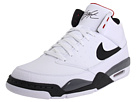

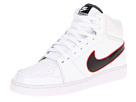

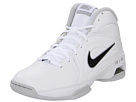

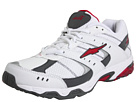

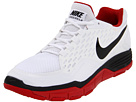

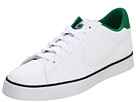

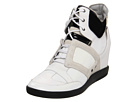

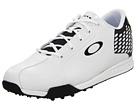

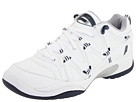

In [ ]:
images = [ PILImage.create(images_path/f) for f in neighbors.path] 
#PILImage.create(btn_upload.data[-1])
for im in images:
    display(im.to_thumb(IMG_SIZE,IMG_SIZE))
          

In [ ]:
#export
def query_neighs(q_feat, myneighs, data, root_path, show = True):
    """
    query feature: (vector)
    myneighs:  fit knn object
    data: series or df containing "path"
    root_path:  path to image files
    """
    distance, nn_index = myneighs.kneighbors(q_feat, return_distance=True)  
    dist = distance.tolist()[0] 

    # fix path to the database...
    neighbors = data.iloc[nn_index.tolist()[0]].copy()
    images = [ PILImage.create(root_path/f) for f in neighbors.path] 
    #PILImage.create(btn_upload.data[-1])
    if show:
        for im in images: display(im.to_thumb(IMG_SIZE,IMG_SIZE))

    return images
        
        

In [ ]:
# export
def get_similar_images(paths_df,model,knns,im_sizes = IMG_SIZES,fnm=None,db=DBS['zappos'],disp=True):
    similar_images = []
    for sz in im_sizes:
        print(SIZE_ABBR[sz])
        print(im_sizes[sz])

        features = f"features_{SIZE_ABBR[sz]}"
        print(features)
        
        if fnm is None:
            im_path = D_ROOT/db
            fnm = im_path/QUERY_IM
            

        query_t = load_and_prep_sneaker(fnm,im_sizes[sz])
        query_f = get_convnet_feature(model,query_t)

        similar_images.append( query_neighs(query_f, knns[sz], paths_df, im_path, show=False) )
        if disp:
            im = PILImage.create(fnm)
            display(im.to_thumb(im_sizes[sz]))
    
    return similar_images


sm
128
features_sm


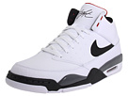

md
160
features_md


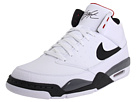

lg
224
features_lg


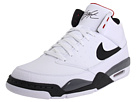

In [ ]:
similar_images =  get_similar_images( paths_df,model,knns)


In [ ]:
# export
def plot_sneak_neighs(images):
    ''' function to plot matrix of image urls. 
        image_urls[:,0] should be the query image
        
    Args: 
        images: list of lists
    
    return: 
        null
        saves image file to directory
    '''
    nrow = len(images)
    ncol = len(images[0])
    
    fig = plt.figure(figsize = (20, 20))

    num=0
    for row,image_row in enumerate(images):
        for col,img in enumerate(image_row):
    
            plt.subplot(nrow, ncol, num+1)
            plt.axis('off')
            plt.imshow(img);

            if num%ncol == 0: 
                plt.title('Query')

            if col>0: 
                plt.title('Neighbor ' + str(col))
            num += 1
    plt.savefig('image_search.png')
    plt.show()
        


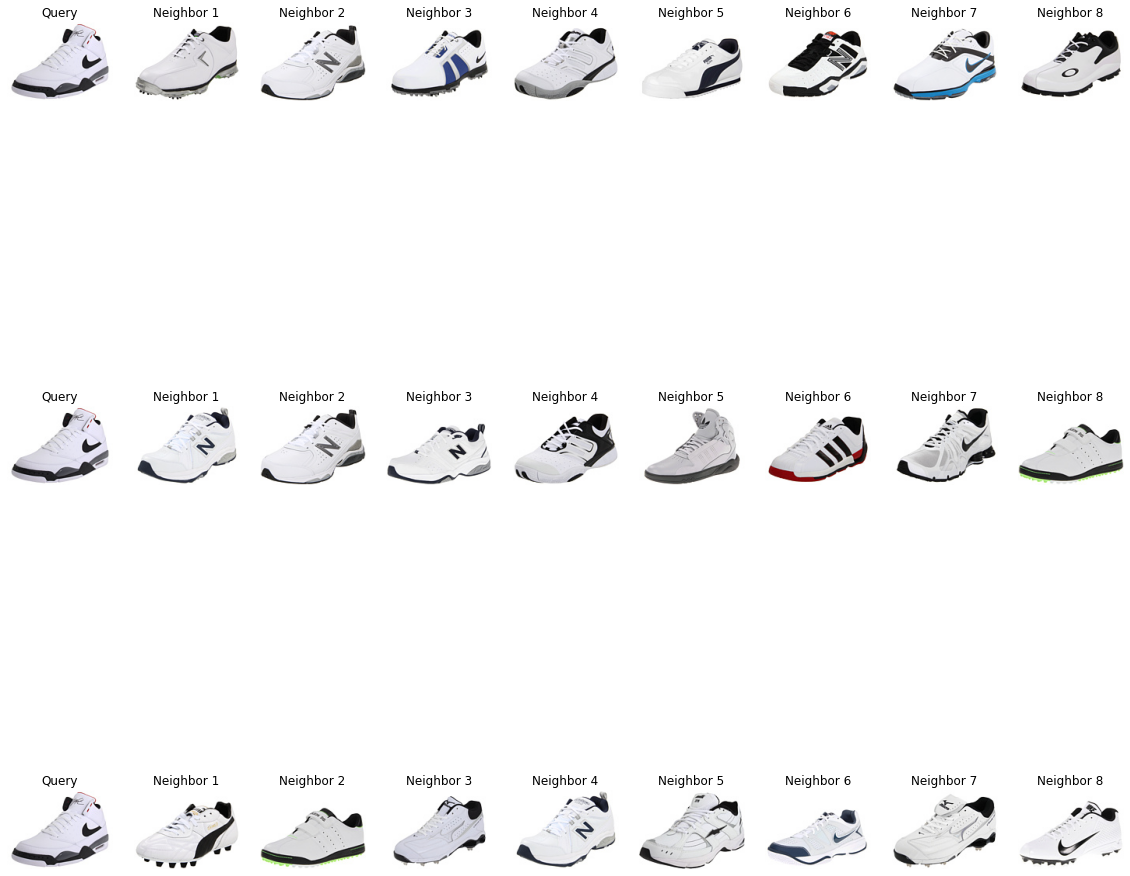

In [ ]:
plot_sneak_neighs(similar_images)


In [ ]:
model = create_cnn_featurenet('mobilenet_v2',to_cuda=True)


similar_images2 = []
for sz in IMG_SIZES:
    print(SIZE_ABBR[sz])
    print(IMG_SIZES[sz])
    
    features = f"features_{SIZE_ABBR[sz]}"
    print(features)

    query_t = load_and_prep_sneaker(QUERY_IM2,IMG_SIZES[sz])
    query_f = get_convnet_feature(model,query_t)
    
    similar_images2.append( query_neighs(query_f, knns[sz], paths, images_path, show=False) )

    im = PILImage.create(QUERY_IM2)
    display(im.to_thumb(IMG_SIZES[sz]))
    
plot_sneak_neighs(similar_images2)


sm
128
features_sm


NameError: name 'paths' is not defined

## visualize the embedding:  PCA + UMAP

sm
128
features_sm
Explained variation per principal component (szsmall): [0.11515645 0.06882259]


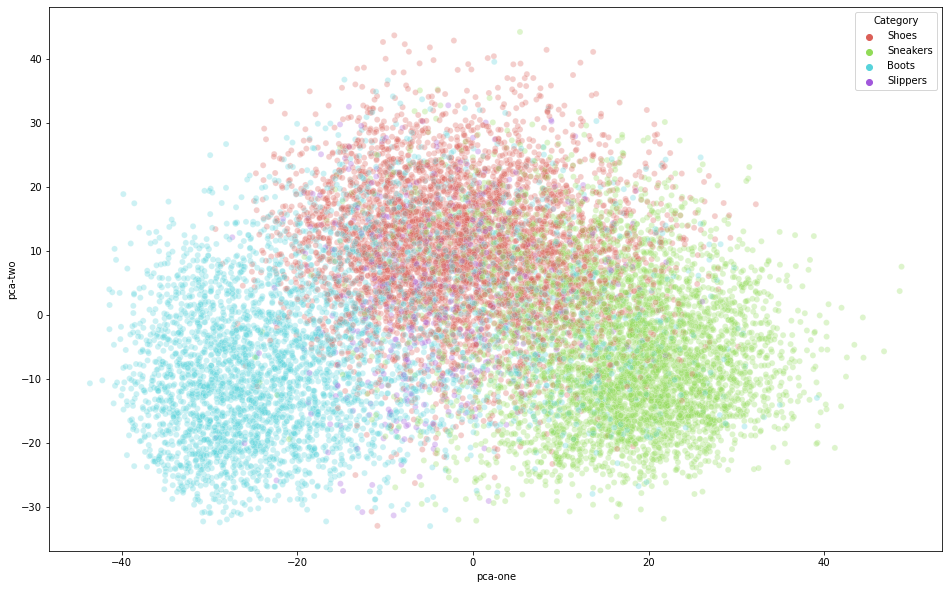

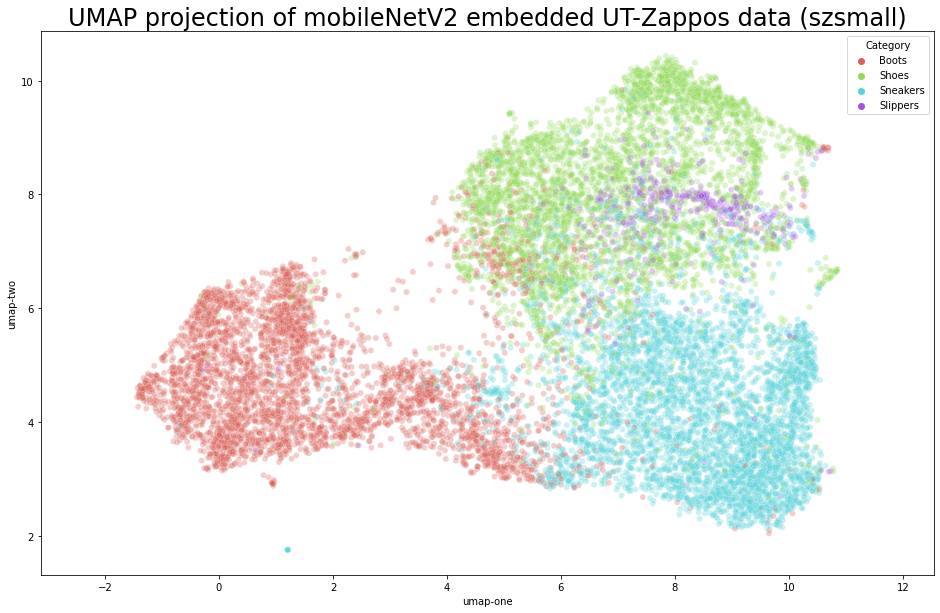

md
160
features_md
Explained variation per principal component (szmedium): [0.12368079 0.07145122]


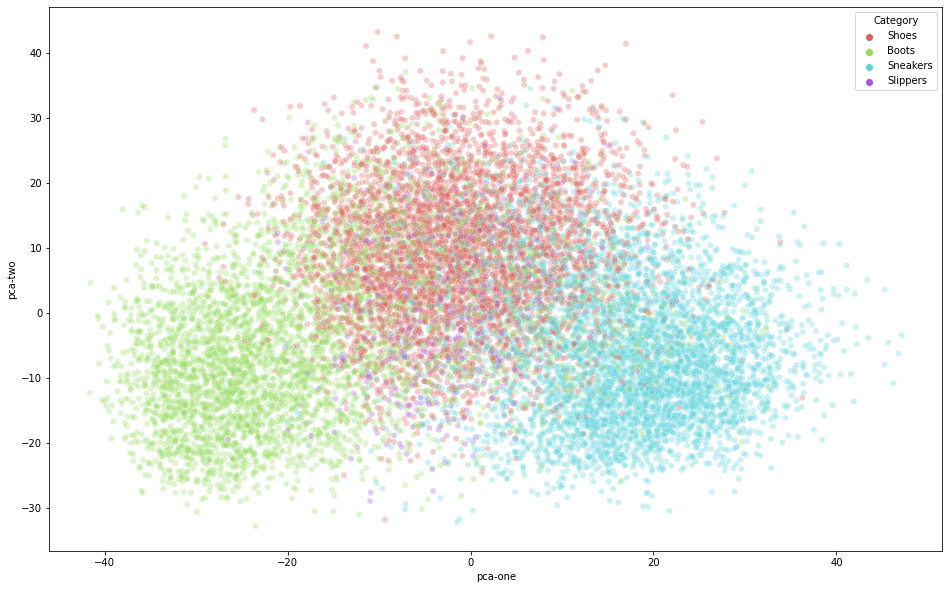

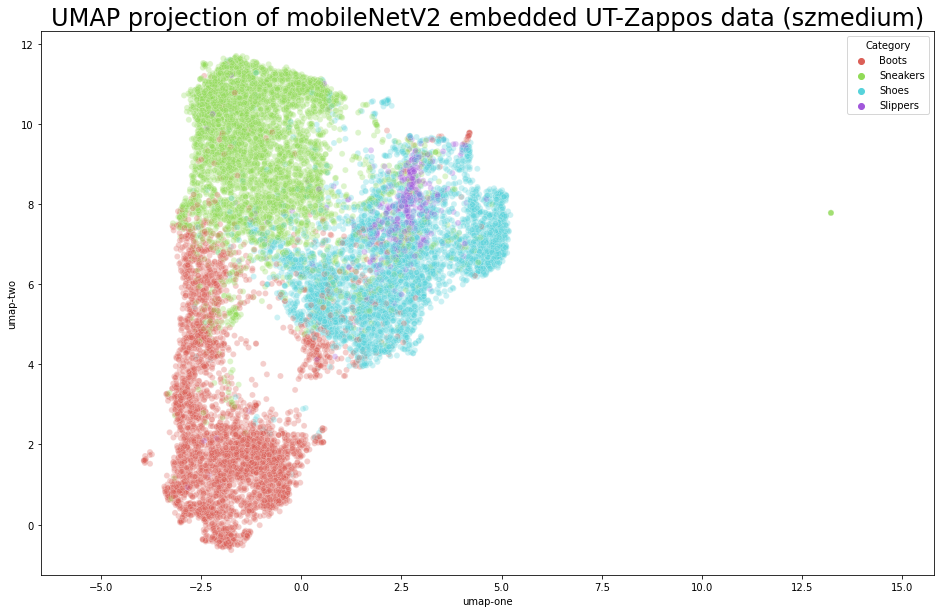

lg
224
features_lg
Explained variation per principal component (szlarge): [0.12368079 0.07145125]


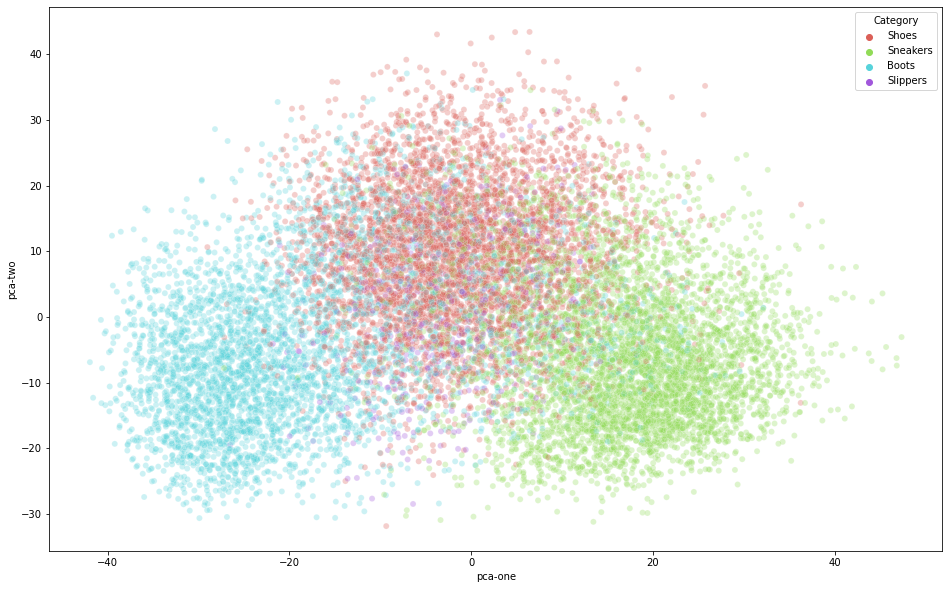

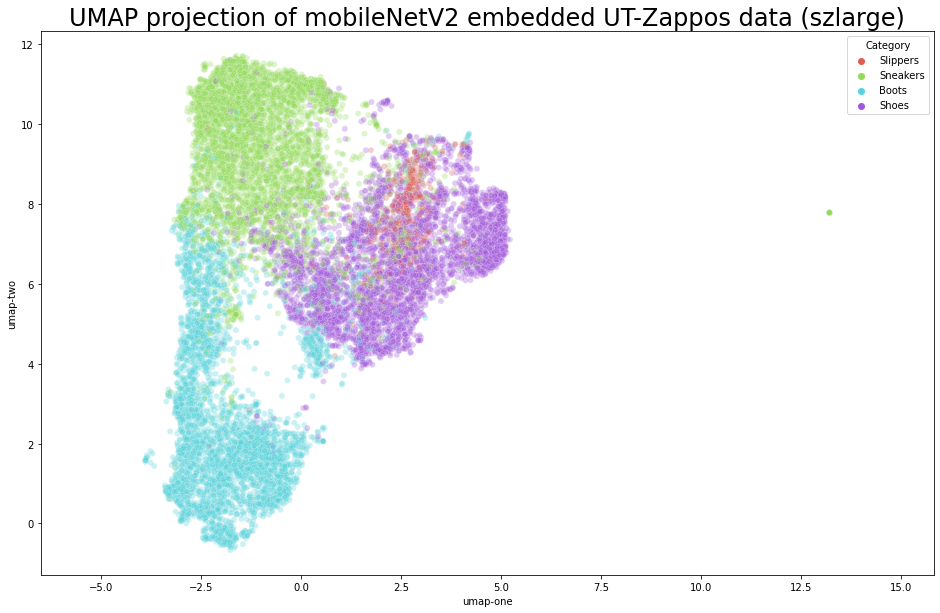

In [ ]:

# first simple PCA
pca = PCA(n_components=2)

for i,sz in enumerate(IMG_SIZES):
    print(SIZE_ABBR[sz])
    print(IMG_SIZES[sz])
    
    features = f"features_{SIZE_ABBR[sz]}"
    print(features)
    
    data = df[['Category',features]].copy()

    db_feats = np.vstack(data[features].values)

    # PCA
    pca_result = pca.fit_transform(db_feats)
    data['pca-one'] = pca_result[:,0]
    data['pca-two'] = pca_result[:,1] 
    print(f"Explained variation per principal component (sz{sz}): {pca.explained_variance_ratio_}")

    smpl_fac=.5
    #data=df.reindex(rndperm)

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca-one",
        y="pca-two",
        hue="Category",
        palette=sns.color_palette("hls", 4),
        data=data.sample(frac=smpl_fac),
        legend="full",
        alpha=0.3
    )
    plt.savefig(f'PCA 2-D sz{sz}')
    plt.show()
    
    
    # get the UMAP on deck
    embedding = reducers[i].transform(db_feats)
    
    data['umap-one'] = embedding[:,0]
    data['umap-two'] = embedding[:,1] 

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="umap-one",
        y="umap-two",
        hue="Category",
        palette=sns.color_palette("hls", 4),
        data=data.sample(frac=smpl_fac),
        legend="full",
        alpha=0.3
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of mobileNetV2 embedded UT-Zappos data (sz{sz})', fontsize=24)
    plt.savefig('UMAP 2-D sz{sz}') 
    plt.show()


In [ ]:
#export
def get_umap_embedding(latents):
    reducer = umap.UMAP(random_state=666)
    reducer.fit(latents)
    embedding = reducer.transform(latents)
    assert(np.all(embedding == reducer.embedding_))
    
    return embedding

In [ ]:
fn = df.path.values
type(db_feats)

snk2vec = dict(zip(fn,db_feats))

snk2vec[list(snk2vec.keys())[0]]

embedding = get_umap_embedding(db_feats)
snk2umap = dict(zip(fn,embedding))
  

In [ ]:
# hide
# from sklearn.manifold import TSNE

# cov_mat =np.cov(vects.T)
# plt.figure(figsize=(10,10))
# sns.set(font_scale=1.5)
# hm = sns.heatmap(cov_mat,
#                  cbar=True,
#                  annot=True,
#                  square=True,
#                  fmt='.2f',
#                  annot_kws={'size': 12},
#                  cmap='coolwarm')
# plt.title('Covariance matrix showing correlation coefficients', size = 18)
# plt.tight_layout()
# plt.show()

## GLM:  Logistic regression on the mobilnet_v2 features: validation and categorization

Note that because we're not really doing parameter fitting, we'll ignore the validation set and add it to training.   

TODO:  make some wrapper functions to perform the classification via Logistic regression.

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[1219   18    2   22]
 [  21 1216   19   73]
 [   3   34   94    7]
 [  37   87    5 1286]]


/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


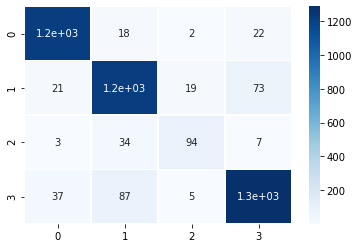

<Figure size 1152x1152 with 0 Axes>

In [ ]:
filename = f"zappos-50k-{model.name}-features_sort_3"

df = pd.read_pickle(f"data/{filename}.pkl")

#Display Confusion Matrix
X_test = np.vstack(df[df.t_t_v=='test']['features_md'])
y_test = np.vstack(df[df.t_t_v=='test']['Category']).flatten()

# use validate and train for training (no validation here)
X_train = np.vstack(df[df.train | df.validate]['features_md'])
y_train = np.vstack(df[df.train | df.validate]['Category']).flatten()


clf_log = LogisticRegression(C = 1, multi_class='ovr', max_iter=2000, solver='lbfgs')
clf_log.fit(X_train, y_train)
log_score = clf_log.score(X_test, y_test)
log_ypred = clf_log.predict(X_test)

log_confusion_matrix = confusion_matrix(y_test, log_ypred)
print(log_confusion_matrix)

disp = heatmap(log_confusion_matrix, annot=True, linewidths=0.5, cmap='Blues')
plt.savefig('log_Matrix.png')


plt.figure(figsize=(16,16))


# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

Confusion matrix, without normalization
[[1219   18    2   22]
 [  21 1216   19   73]
 [   3   34   94    7]
 [  37   87    5 1286]]
Normalized confusion matrix
[[0.9666931  0.01427439 0.00158604 0.01744647]
 [0.01580135 0.91497366 0.01429646 0.05492852]
 [0.02173913 0.24637681 0.68115942 0.05072464]
 [0.02614841 0.0614841  0.00353357 0.90883392]]


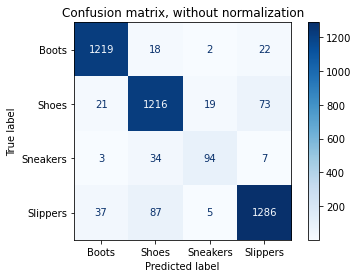

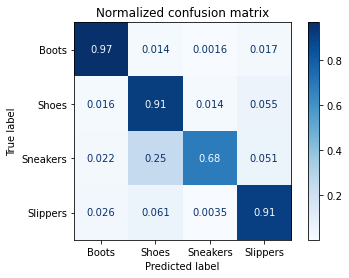

In [ ]:
class_names = df.Category.unique()

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_log, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('log_Matrix2.png')

## export

In [ ]:


from nbdev.export import notebook2script
notebook2script()



Converted 00_core.ipynb.
Converted 01a_zappos_data.ipynb.
Converted 01b_scraped_data.ipynb.
Converted 02_model.ipynb.
Converted 03a_cvae.ipynb.
Converted index.ipynb.


In [ ]:
# hide

# ### NOTE: these are from https://walkwithfastai.com/Style_Transfer

# # these are the convlayer "features" to define style for styletransfer
# _vgg_config = {
#     'vgg16' : [1, 11, 18, 25, 20],
#     'vgg19' : [1, 6, 11, 20, 29, 22]
# }

# from torchvision.models import vgg19, vgg16

# feat_net = vgg19(pretrained=True).features.cuda().eval()

# def get_feats(arch:str, pretrained=True):
#     "Get the features of an architecture"
#     feat_net, layers = _get_layers(arch, pretrained)
#     hooks = hook_outputs(layers, detach=False)
#     def _inner(x):
#         feat_net(x)
#         return hooks.stored
#     return _inner



# def _get_layers(arch:str, pretrained=True):
#     "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
#     feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
#     config = _vgg_config.get(arch)
#     features = feat_net.features.cuda().eval()
#     for p in features.parameters(): p.requires_grad=False
#     return feat_net, [features[i] for i in config]



# feats = get_feats('vgg19')
